In [97]:
'''
###################
Author: Zynab Smaan
####################
###############################################################################
Class Model:- This class for loading data, pre-processing it and training it to
              build a multiple classifier.
              
**Functions:-
   *get_data         : To load the data from the folder and returns two arrays
                      images and labels.

   *compute_sift     : To compute the descriptors of the point of interests
                       returns either all descriptors of all images or just  
                       descriptors of one image.
                       
   *cluster_features : To create clusters from all descriptors due to 
                       similarties and return the model using kmeans.
                       
   *create_histogram : To build histogram from clusters by count up how many 
                       each descriptor appears and return the histogram.
                       
   *compute_SPM      : To build the spatial pyramid histogram and return it.
   
   *get_all_hitograms: To get all the histograms of all the data.
   
   *perpare_data     : To apply the whole steps of pre-processing as well as 
                       split the data and return training and testing sets.
                       
   *model_SVM        : To build and train the SVM model and return the 
                       resulting accuracy.
###############################################################################
'''

'\n###################\nAuthor: Zynab Smaan\n####################\n###############################################################################\nClass Model:- This class for loading data, pre-processing it and training it to\n              build a multiple classifier.\n              \n**Functions:-\n   *get_data        : To load the data from the folder and returns two arrays\n                      images and labels.\n\n   *compute_sift     : To compute the descriptors of the point of interests\n                       returns either all descriptors of all images or just  \n                       descriptors of one image.\n                       \n   *cluster_features : To create clusters from all descriptors due to \n                       similarties and return the model using kmeans.\n                       \n   *create_histogram : To build histogram from clusters by count up how many \n                       each descriptor appears and return the histogram.\n                     

<h4>Import dependencies.</h4>

In [98]:
import numpy as np
import cv2
import pickle
import math
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

%inline matplotlib

UsageError: Line magic function `%inline` not found.


<h4>Expolor the images </h4>

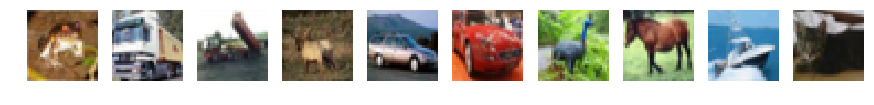

In [36]:
fig, axes1 = plt.subplots(1, 10, figsize=(15,15))
for k in range(10):
        axes1[k].set_axis_off()
        axes1[k].imshow(x[k])


<h4>Build class Model for handling all the step of the work of the work.</h5>

In [105]:
class Model(object):
    def __init__(self):
        pass
    
    def get_data(self):
        '''
        This function for reading the data from the file and store it
        in numpy array as images and labels
        
        returns:-
        images: numpy array of size (50000, 32, 32, 3).
        lable : numpy array of size (50000, 1). 
        
        '''
        
        # For storeing the output of the function
        images = []
        labels = []
        
        # Loop through each file in the folder to be read.
        for batch_id in range(1, 6):
            
            # Open the file and read the data.
            with open('cifar-10-batches-py' + '/data_batch_' + str(batch_id), mode='rb') as file:
                # note the encoding type is 'latin1'
                batch = pickle.load(file, encoding='latin1')
            
            # append each patch to other patches
            images.append(batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1).astype("uint8"))
            labels.append(batch['labels'])
        
        # Now the images array has the size (5, 10000, 32, 32, 3) let's reshape it 
        # to the shape (50000, 32, 32, 3). Also reshaping labels array to have the 
        # size (50000,1)
        images = np.reshape(np.array(images), (50000, 32, 32, 3))        
        labels = np.reshape(np.array(labels), (50000, -1))

        
        # Convert labels to one hot vector
        one_hot = LabelBinarizer()
        one_hot_labels = color_lb.fit_transform(labels)
        
        # return the result.
        return images, labels, one_hot_labels
    
    
    
    def compute_sift(self, data, is_image=True):
        '''
        This function to compute SIFT descriptors of the input data..
        params:-
            data    : Numerical input images to compute its features - type: list.
            is_image: will return the descriptors of one image if True. And returns 
                      all descriptors stacked together from multiple images as 2d 
                      array- type: boolean. 
        output:-
            train_x:      the computed features from the data. It will be our new 
                          input on predicting. - type :(numpy array).

            descriptors: contains all the descriptors from all images in 2d numpy array.

        '''

        # Empty list to store the output.
        train_x = []

        # loop through all the images.
        for img in data:

            # Create object of xFeatures. 
            sift = cv2.xfeatures2d.SIFT_create()


            # Getting the point of interests to be feed to "sift" as params to extract descriptors.
            # Step size = 1 .
            kp = [cv2.KeyPoint(x, y, 1) for x in range(img.shape[0]) for y in range(img.shape[1])]


            # Getting the descriptors from the image.
            dense_feat = sift.compute(img, kp)


            #Appendig descriptors of the image together. 
            train_x.append(dense_feat[1])


        train_x = np.array(train_x)

        if is_image:
            # one image
            return train_x[0]
        else:
            # more than one image
            # To Get all the descriptors as 2d array we need to reshape it and store it in "descriptors"
            return train_x.reshape(-1, 128)

    
    def cluster_features(self, descriptors, k):
        kmeans = KMeans(n_clusters=k, random_state=0).fit(descriptors)
        return kmeans
    
    
    def create_histogram(self, image, KMeans, k):
        '''
        After getting clusters for all data we need to build histograms
        for each image to represent it according to all culsters

        Params:- 
            image      : Input image as features - type: numpy array
            KMeans     : The modle we train to predict each feature to its cluster.

        Output:-
            return the image as histograms. 
        '''

        # Assign each feature to each class.
        predict = KMeans.predict(image)

        return np.bincount(predict, minlength=k)
    
    
    
    
    def compute_SPM(self, image, L, k, kmeans):
        '''
        Compute spatial pyramid matching for an image at all levels into one histogram.

        params:
            image: 
            L      : Number of levels.
            k      : Number of clusters.
            kmeans : The model that's used in prediction.

        output:
            final_histogram: The final histogram of the 

        '''


        # Get height and width of one image.
        width = image.shape[1]
        height = image.shape[0]

        # final histogram of an image.
        final_histogram = []


        # Loop through levels.
        for l in range(L):

            # Weight for each histogram according to each level.

            weight = 2 **l

            # Compute the width and height of each subregion of the image
            # according to the current level.

            width_step = math.floor(width/2**l)
            height_step = math.floor(height/2**l)

            # The start point of first region.
            x, y = 0, 0

            # Loop through x axis. l represents the level if it's 1 it means the 
            # image will be divided into 4 subregions. Formulation 2**l for each
            # dimension.

            # Loop through all regions of the image in y direction.
            for i in range(l, l+1):
                x = 0

                # Loop through all regions in x direction.
                for j in range(1, l+1):

                    # Get the sub region of the image
                    region = image[y:height_step, x:width_step]

                    # Get the descriptors of the subregion of the image.

                    descriptors = self.compute_sift([region], True)

                    # Build the histogram for each sub regions
                    hist = self.create_histogram(descriptors, kmeans, k)

                    # stack histograms together
                    final_histogram.append(hist*weight)

                    # Increase the x by the step side to move to the next region.
                    x += width_step

                # Increase the y by the step side to move to the next region.
                y += height_step


        final_histogram = np.array(final_histogram).ravel()

        # Normalize the histogram to have means = 0.

        final_histogram = (final_histogram - np.mean(final_histogram))/np.std(final_histogram)


        return final_histogram
    
    
    
    def get_all_histograms(self, data, L, kmeans, k): 
    
        '''
        Get all histograms for all images.
        Params:-
            data   : Numerical input images to compute its features - type: list.
            L      : Number of levels - type: int.
            kmeans : The model using in prediction.
            k      : Number of clusters.

        Output:-
            returns all the histogram of images.

        '''

        # Store all histograms here.
        histograms = []

        # Loop through images.
        for x in data:

            # Get the sptial histogram of an image.
            hist = self.compute_SPM(x, L, k, kmeans) 

            # Append all histograms
            histograms.append(hist)

        # Return all histogram data.    
        return np.array(histograms)
    
    
    
    def perpare_data(self, X, Y, kmeans, K, L):
        
        '''
        This function to perpare data and split it into
        train and test data.
        params:-
            X : Numerical input data - type: numpy.
            Y : list of labels - type: int.
            K : The number of clusters - type: int.
            L : Number of levels - type: int.
            
        returns:
            x_train, x_test, y_train, y_test.    
        
        '''
        
        # Shuffle the data first.
        X, Y = shuffle(X, Y, random_state=0)

        # Split the data to train and test sets.
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

        # Get train descriptors.
        train_descriptors = self.compute_sift(x_train, False)

        # Train kmeans.
        kmeans = self.cluster_features(train_descriptors, k)

        # convert data to histograms
        x_train = self.get_all_histograms(x_train, L, kmeans, k)
        x_test = self.get_all_histograms(x_test, L, kmeans, k)
        
        return x_train, x_test, y_train, y_test

    
    def model_SVM(self, x_train, x_test, y_train, y_test):
    
        '''
        Create the model, train it and test its accuracy.
        params:-
            x_train, x_test, y_train, y_test

        '''
        
        print("Start training the model.........")
        clf = svm.SVC(C=1000, gamma=.0001)
        clf.fit(x_train, y_train)  
        print("End training the model...........")
        
        # Compute the training accuracy.
        pred_train_y = clf.predict(x_train)
        train_acc = accuracy_score(y_train, pred_train_y)

        # Compute the testing accuracy.
        pred_test_y = clf.predict(x_test)
        test_acc = accuracy_score(y_test, pred_test_y)


        print("The training acc is {}".format(train_acc))
        print("The testing acc is {}".format(test_acc))
        
        
        
    def gray_scale(self, images):
        
        '''
        This function to convert images from RGB to GRAY
        params:-
        images: the numerical input data.
        
        '''
        data = []
        for image in images:
            data.append(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
        return np.array(data)
                    

In [106]:
# Create istace of the class
obj = Model()

<h2>SVM</h2>

In [102]:
L = 2
k = 60

# Get the data
print("Getting the data .................")
images, labels, one_hot_labels = obj.get_data()

sub_images, sub_labels = images[0:500], labels[0:500]
# Get all descriptors
print("Get all descriptors...............")
all_descriptors = obj.compute_sift(sub_images, False)

# Cluster descriptors 
print("Cluster all the descriptor........")
kmeans = obj.cluster_features(all_descriptors, k)

# Perpare and split the data.
print("Perparing the data................")
x_train, x_test, y_train, y_test = obj.perpare_data(sub_images, sub_labels, kmeans, k, L)

print("Training the model................")
obj.model_SVM(x_train, x_test, y_train, y_test)

Getting the data .................
Get all descriptors...............
Cluster all the descriptor........
Perparing the data................
Training the model................
Start training the model.........
End training the model...........
The training acc is 0.1375
The testing acc is 0.1


C:\Users\ADMIN\Anaconda\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:

Note That: The training accuracy(13.75%) is terrible and so thet the testing acc is 10%. We 
    need to make the model more complex or try another technique. It may also that SPM isn't good for recognition tasks
    as it just cares about the existance of the object not it's location 

<h2>SVM - Grayscale</h2>

In [107]:
L = 2
k = 60

# Get the data
print("Getting the data .................")
images, labels, one_hot_labels = obj.get_data()

# Divide the data.
sub_images, sub_labels = obj.gray_scale(images[0:500]), labels[0:500]


# Get all descriptors
print("Get all descriptors...............")
all_descriptors = obj.compute_sift(sub_images, False)

# Cluster descriptors 
print("Cluster all the descriptor........")
kmeans = obj.cluster_features(all_descriptors, k)

# Perpare and split the data.
print("Perparing the data................")
x_train, x_test, y_train, y_test = obj.perpare_data(sub_images, sub_labels, kmeans, k, L)

print("Training the model................")
obj.model_SVM(x_train, x_test, y_train, y_test)

Getting the data .................
Get all descriptors...............
Cluster all the descriptor........
Perparing the data................
Training the model................
Start training the model.........
End training the model...........
The training acc is 0.725
The testing acc is 0.18


C:\Users\ADMIN\Anaconda\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
L = 2
k = 60

# Get the data
print("Getting the data .................")
images, labels, one_hot_labels = obj.get_data()

# Divide the data.
sub_images, sub_labels = obj.gray_scale(images[0:]), labels[0:500]


# Get all descriptors
print("Get all descriptors...............")
all_descriptors = obj.compute_sift(sub_images, False)

# Cluster descriptors 
print("Cluster all the descriptor........")
kmeans = obj.cluster_features(all_descriptors, k)

# Perpare and split the data.
print("Perparing the data................")
x_train, x_test, y_train, y_test = obj.perpare_data(sub_images, sub_labels, kmeans, k, L)

print("Training the model................")
obj.model_SVM(x_train, x_test, y_train, y_test)